# Extract focal regions from human performance

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

import sys

sys.path.append('../src')

from Config.config import PATHS
from Utils.utils import PPT
from Utils.bar_utils import BarRenderer
from Classes.focal_regions import SetFocalRegions

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Loading data...")
file_name = PATHS['human_data'] / 'all_data.csv'
data_human = pd.read_csv(file_name)
data_human['model'] = 'human'

# Get the datasets for each treatment
data_downwards = data_human[data_human['treatment'] == 'downwards'].copy()
data_upwards = data_human[data_human['treatment'] == 'upwards'].copy()
dataset_names = ['all', 'downwards', 'upwards']

df_results = pd.DataFrame(columns=[
    'dataset', 'num_agents', 'threshold', 
    'number_focal_schemata', 'number_best_schemata', 'mean_similarity_score'
])


Loading data...


In [227]:
SIM_THRESHOLD = 0.8

delta_frequency = pd.DataFrame(None, columns=['Group', 'num_agents', 'threshold', 'Max_similarity'])

# Iterate over datasets
for idx, data in enumerate([data_human, data_downwards, data_upwards]):

    print(f"Processing dataset {dataset_names[idx]}...")

    list_fixed_parameters = PPT.get_fixed_parameters(data)
    print(f"Number of fixed parameters combinations: {len(list_fixed_parameters)}")

    for i, fixed_parameters in enumerate(list_fixed_parameters):

        if fixed_parameters['num_agents'] not in [3]: continue # Less than 5 agents for now

        row_dataset = dataset_names[idx]

        print(f"Processing fixed parameters ({i}/{len(list_fixed_parameters)}):\n{fixed_parameters}")
        row_num_agents = fixed_parameters['num_agents']
        row_threshold = fixed_parameters['threshold']

        sfr_parameters = {
            'num_agents': fixed_parameters['num_agents'],
            'threshold': fixed_parameters['threshold'],
            'len_history': fixed_parameters['num_agents'],
            'max_regions': 4 * fixed_parameters['num_agents'],  # Arbitrary large number
            'from_file': False
        }

        print(f"\tGenerating focal regions...")
        sfr = SetFocalRegions(**sfr_parameters)
        sfr.generate_focal_regions()
        sfr.focal_regions = list(set(sfr.focal_regions))  # Remove duplicates
        print(f"\tNumber of focal regions: {len(sfr)}")
        row_number_focal_schemata = len(sfr)

        data_session = data_human[
            (data_human['num_players'] == fixed_parameters['num_agents']) &
            (data_human['threshold'] == fixed_parameters['threshold'])
        ].copy()

        best_fitting_regions = []

        for key, grp in data_session.groupby('group'):
            bar_renderer = BarRenderer(data=grp)
            history = np.array(bar_renderer.get_history()).T[:, :20]

            if dataset_names[idx] == 'all':
                group_sims = []

            for i, region in enumerate(sfr.focal_regions):
                sim_score = region.get_long_history_similarity_score(history)
                best_fitting_regions.append((i, sim_score))

                if dataset_names[idx] == 'all':
                    group_sims.append(sim_score)
    
            if dataset_names[idx] == 'all':
                delta_frequency.loc[len(delta_frequency)] = {
                    "Group": key, 
                    "num_agents": fixed_parameters['num_agents'],
                    "theshold": fixed_parameters['threshold'],
                    "Max_similarity": max(group_sims)
                }

        best_fitting_regions = pd.DataFrame(best_fitting_regions, columns=['region_id', 'similarity_score'])

        # Get best fitting regions
        focal_regions_ids = best_fitting_regions[best_fitting_regions['similarity_score'] > SIM_THRESHOLD]['region_id'].values
        row_mean_sim_score = best_fitting_regions[best_fitting_regions['similarity_score'] > SIM_THRESHOLD]['similarity_score'].mean()
        focal_regions_ids = list(set(focal_regions_ids))
        focal_regions = [sfr.focal_regions[i] for i in focal_regions_ids]
        sfr.focal_regions = focal_regions

        # Save focal regions
        if idx == 0:  # Only save for the full dataset
            sfr.file = Path('../data/focal_regions') / f"_{sfr.num_agents}_agents_{sfr.threshold}_threshold.npy"
            sfr.save_focal_regions()

        print(f"\tNumber of best fitting regions: {len(focal_regions)}")
        row_number_best_schemata = len(focal_regions)

        df_results.loc[len(df_results)] = [
            row_dataset, row_num_agents, row_threshold, 
            row_number_focal_schemata, row_number_best_schemata, row_mean_sim_score
        ]

    print(f"Finished with dataset {dataset_names[idx]}!")

# df_results.to_csv('focal_schemata_summary.csv', index=False)

Processing dataset all...
Number of fixed parameters combinations: 27
Processing fixed parameters (11/27):
{'num_agents': 3, 'threshold': 0.6666666666666666}
	Generating focal regions...
	Number of focal regions: 6
	Number of best fitting regions: 1
Processing fixed parameters (13/27):
{'num_agents': 3, 'threshold': 0.3333333333333333}
	Generating focal regions...
	Number of focal regions: 5
	Number of best fitting regions: 1
Finished with dataset all!
Processing dataset downwards...
Number of fixed parameters combinations: 11
Processing fixed parameters (3/11):
{'num_agents': 3, 'threshold': 0.6666666666666666}
	Generating focal regions...
	Number of focal regions: 6
	Number of best fitting regions: 1
Processing fixed parameters (5/11):
{'num_agents': 3, 'threshold': 0.3333333333333333}
	Generating focal regions...
	Number of focal regions: 5
	Number of best fitting regions: 1
Finished with dataset downwards!
Processing dataset upwards...
Number of fixed parameters combinations: 26
Pr

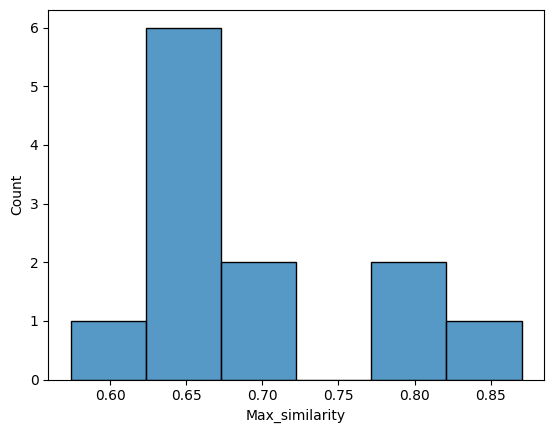

In [255]:
sns.histplot(delta_frequency['Max_similarity'])
plt.show()

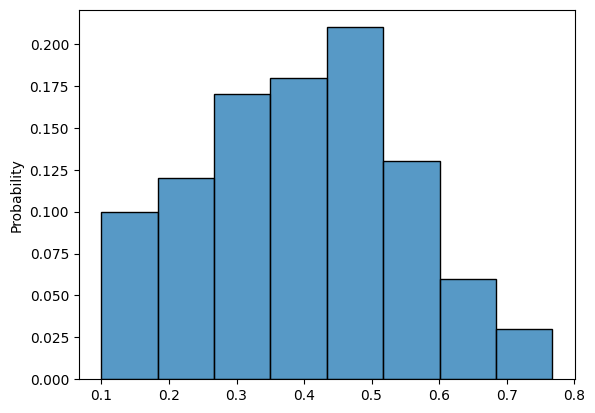

In [365]:
def sample_pareto(alpha, size=100, rng=None):
    rng = rng or np.random.default_rng()
    u = rng.random(size)
    sample = np.power(u, -alpha)
    return sample

def sample_exp(alpha, size=100, rng=None):
    rng = rng or np.random.default_rng()
    u = rng.random(size)
    sample = np.exp(u * -alpha)
    return sample

# # Exponential relation
# params = {
#     "alpha":2,
# }
# data = sample_exp(**params, size=100)


# # Power law
# params = {
#     "alpha":2,
# }
# data = sample_pareto(**params, size=100)

from scipy.stats import beta

params = {
    "a":4,
    "b":6,
}
data = beta.rvs(**params, size=100)

sns.histplot(data, stat="probability")
plt.show()

<Axes: ylabel='Probability'>

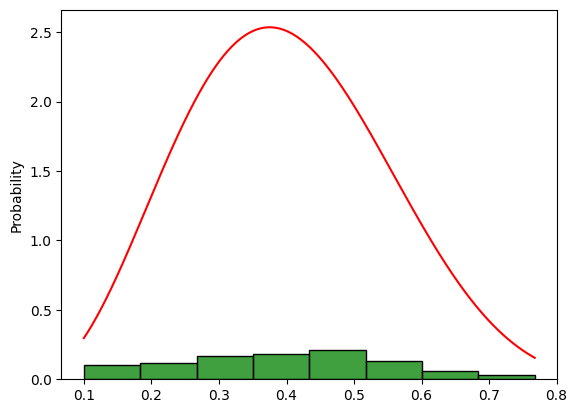

In [369]:
def model_pdf(x, a, b):
    # return np.exp(x * (-alpha))
    # return np.power(x, -alpha)
    return beta.pdf(x, a, b)

def empirical_freqs(x, b=10):
    x = np.asarray(x).astype(int)
    counts, bin_edges = np.histogram(data, bins=10)
    probs = counts / counts.sum()
    return probs, bin_edges

emp_probs, bin_edges = empirical_freqs(data)
bin_len = bin_edges[1] - bin_edges[0]
bin_centers = (bin_edges + 0.5 * bin_len)[:-1].round(2)
X = np.linspace(data.min(), data.max(), 1000)
Y = model_pdf(X, **params)

# sns.barplot(x=bin_centers, y=emp_probs, color='blue')
sns.histplot(data, stat="probability", color='green')
sns.lineplot(x=X, y=Y, color='red', markers='-')

In [371]:
from scipy.optimize import minimize, Bounds
from bayes_opt import BayesianOptimization

kind = "kl"

def loss_fn(emp_probs, model_probs, kind="mse", eps=1e-12):
    if kind == "mse":
        return float(np.mean((emp_probs - model_probs) ** 2))
    elif kind == "kl":
        # KL(emp || model)
        p = np.clip(emp_probs, eps, 1.0)
        q = np.clip(model_probs, eps, 1.0)
        p = p / p.sum()
        q = q / q.sum()
        return float(np.sum(p * np.log(p / q)))
    else:
        raise ValueError("kind must be 'mse' or 'kl'")

def bbfunction(a, b):
    model_probs = model_pdf(emp_probs, a, b)
    return loss_fn(emp_probs, model_probs, kind=kind)

def black_box_function(params) -> float:
    return bbfunction(**params)

model_probs = model_pdf(emp_probs, **params)
print(f"Loss: {loss_fn(emp_probs, model_probs, 'kl')}")
print(f"bbfunction: {bbfunction(**params)}")
print(f"Black box: {black_box_function(params)}")

Loss: 0.14671167735339397
bbfunction: 0.14671167735339397
Black box: 0.14671167735339397


In [377]:
lower_bounds = [0, 1e-4]
upper_bounds = [10, 10]
args = list(params.keys())
pbounds = {
    args[0]: [lower_bounds[0], upper_bounds[0]],
    args[1]: [lower_bounds[1], upper_bounds[1]],
}
print(f"pbounds: {pbounds}")

# Scipy optimizer
x0 = [0.5, 1]
result = minimize(
    lambda x: bbfunction(a=x[0], b=x[1]),
    x0=x0,
    bounds=Bounds(lower_bounds, upper_bounds),
    method='L-BFGS-B'
)
one = result.x[0]
two = result.x[1]
loss = result.fun

# # Bayesian optimizer
# optimizer = BayesianOptimization(
#             f=lambda alpha: -bbfunction(alpha),
#             pbounds=pbounds,
#             random_state=1,
#             allow_duplicate_points=False,
#             verbose=0
#         )
# optimizer.maximize(
#     init_points=8,
#     n_iter=10,
# )
# one = optimizer.max['params'][args[0]]
# # two = optimizer.max['params'][args[1]]
# loss = optimizer.max['target']

print(f"Loss: {loss}\n\t--- {args[0]}:{one}\n\t--- {args[1]}: {two}")
# print(f"Loss: {loss}\n\t--- {args[0]}:{one}")

pbounds: {'a': [0, 10], 'b': [0.0001, 10]}
Loss: 0.13650797339438422
	--- a:0.5
	--- b: 1.0


<Axes: ylabel='Probability'>

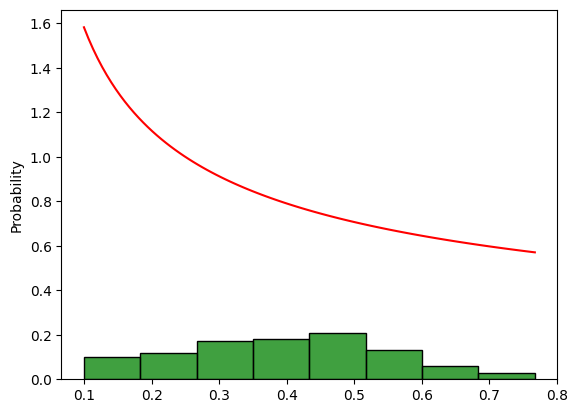

In [380]:
X = np.linspace(data.min(), data.max(), 100)
Y = model_pdf(X, one, two)

# sns.barplot(x=bin_centers, y=emp_probs, color='blue')
sns.histplot(data, stat="probability", color='green')
sns.lineplot(x=X, y=Y, color='red', markers='-')

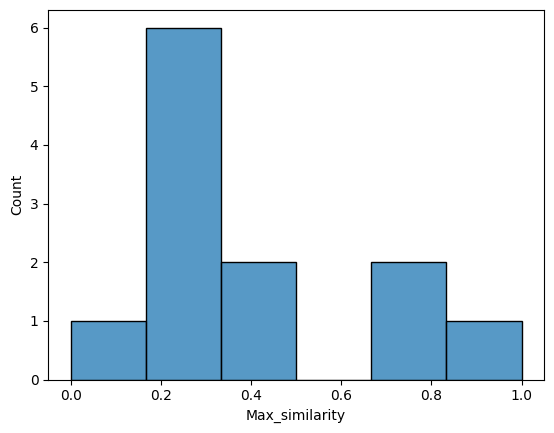

In [386]:
# Using similarities to schemata
data = delta_frequency['Max_similarity']
# Normalizing
MIN_FREQ = data.min()
MAX_FREQ = data.max()
normalized_data = (data - MIN_FREQ) / (MAX_FREQ - MIN_FREQ)
sns.histplot(normalized_data)
plt.show()

Loss: -0.05798519664659535
	--- a:4.17022004702574
	--- b: 7.203272901972237


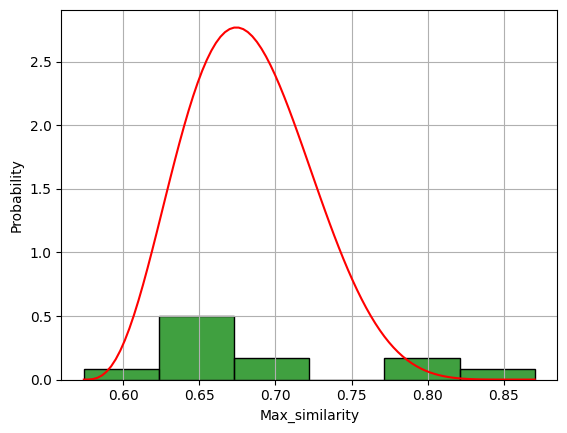

In [388]:
emp_probs, bin_edges = empirical_freqs(normalized_data)

def bbfunction(a, b):
    model_probs = model_pdf(emp_probs, a, b)
    return loss_fn(emp_probs, model_probs, kind=kind)


# x0 = [0.5, 1]
# # Define optimizer
# result = minimize(
#     black_box_function,
#     x0=x0,
#     bounds=Bounds(lower_bounds, upper_bounds),
#     method='L-BFGS-B'
# )
# mu = result.x[0]
# sigma = result.x[1]
# loss = result.max

# Bayesian optimizer
optimizer = BayesianOptimization(
            f=lambda a, b: -bbfunction(a, b),
            pbounds=pbounds,
            random_state=1,
            allow_duplicate_points=False,
            verbose=0
        )
optimizer.maximize(
    init_points=2,
    n_iter=3,
)
one = optimizer.max['params'][args[0]]
two = optimizer.max['params'][args[1]]
loss = optimizer.max['target']

print(f"Loss: {loss}\n\t--- {args[0]}:{one}\n\t--- {args[1]}: {two}")


bin_len = bin_edges[1] - bin_edges[0]
bin_centers = (bin_edges + 0.5 * bin_len)[:-1].round(2)

X = np.linspace(0, 1, 100) 
Y = model_pdf(X, one, two)
X = X * (MAX_FREQ - MIN_FREQ) + MIN_FREQ

# sns.barplot(x=bin_centers, y=emp_probs, color='blue')
sns.histplot(data, stat="probability", color='green')
sns.lineplot(x=X, y=Y, color='red', markers='-')
plt.grid()
plt.show()

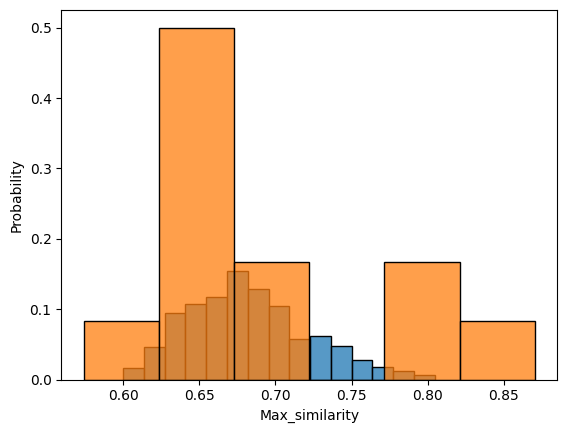

In [383]:
data_ = beta.rvs(one, two, size=500)
data_ = data_ * (MAX_FREQ - MIN_FREQ) + MIN_FREQ

sns.histplot(data_, stat="probability", legend="Sim")
sns.histplot(delta_frequency['Max_similarity'], stat="probability", legend="Obs")
plt.show()

### Show results

In [17]:
file_path = PATHS['focal_regions_path'] / 'focal_schemata_summary.csv'
data_summary = pd.read_csv(file_path)
data_summary = data_summary[data_summary['dataset'] != 'all']

# Change round to round within session
dict_num_sessions = {i: 3 for i in range(4, 13)}
dict_num_sessions[2] = 2
dict_num_sessions[3] = 2


group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(num_players, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(num_players, threshold)] = count
    else:
        dict_sessions_downwards[(num_players, threshold)] = 1

dict_sessions = {
    'downwards': dict_sessions_downwards,
    'upwards': dict_sessions_upwards
} 

data_summary['session'] = data_summary.apply(lambda row: dict_sessions[row['dataset']][(row['num_agents'], row['threshold'])], axis=1)

data_summary.head()

,dataset,num_agents,threshold,number_focal_schemata,number_best_schemata,mean_similarity_score,segmented,alternation,mixed,session
27,downwards,4,0.750000,15,0,NaN,0,0,0,1
28,downwards,4,0.500000,16,0,NaN,0,0,0,2
29,downwards,4,0.250000,10,1,1.0,1,0,0,3
30,downwards,3,0.666667,9,0,NaN,0,0,0,1
31,downwards,5,0.800000,19,0,NaN,0,0,0,1


<Axes: xlabel='threshold', ylabel='number_best_schemata'>

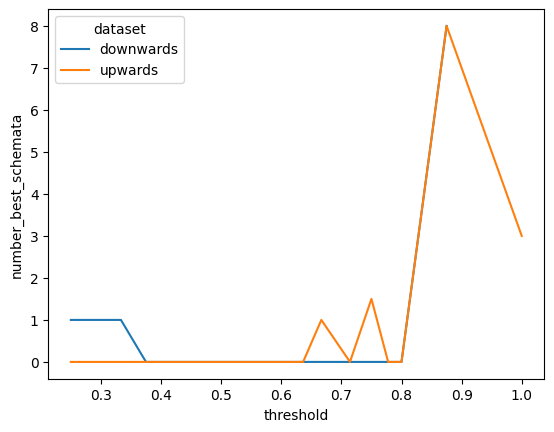

In [18]:
sns.lineplot(
    x='threshold',
    y='number_best_schemata',
    hue='dataset',
    data=data_summary,
    errorbar=None
)

---